# Introduction
In this Jupyter notebook, we investigate the [Airbnb Munich dataset](http://insideairbnb.com/get-the-data.html) (date of retrieval: 24th of December 2020). 
<br> The structure of this notebook follows the CRISP-DM process, consisting of the following five steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modeling
5. Results Evaluation

Whereas the first three steps are performed for all of the following business questions, the data modeling step and the results evaluation step are done successively for each of the following business question. 

# Business Understanding

In this project, we want to answer the following three questions, which might be relevant for tourists staying in an Airbnb listing in Munich in 2021:

1. In which months are most Airbnb listings still available (total and by room type)?
2. In which Munich areas (zip codes) are the best Airbnb listings (according to total rating)?
3. Do cheaper listings have a lower rating compared to more expensive listings? 

# Data understanding

For answering the questions, we will focus on the following data:

1. For the first question, we will use data from the calendar.csv file. This file includes dates, prices, availability information as well as the number of overnight stays for each Airbnb listing. Relevant columns for us are "listing_id", "date", and "available". In addition, we will use the column "room_type" from the listing.csv file, which includes a detailed description of each Airbnb listing.

2. For the second question, we will use data from the listing.csv file. Relevant columns for us are "id" (of the listing), "review_scores_rating" (total rating score), "latitude", and "longitude". We will use the latitude and longitude data to obtain the zip code for each listing, using [geographic data from Germany](https://www.suche-postleitzahl.org/plz-karte-erstellen). Relevant columns of the geographic data are "plz" (zip code), and "geometry". 

3. For the third question, we will use data from the listing.csv file. Relevant columns for us are "id" (of the listing), "review_scores_rating" (total rating score), and "price". 

In [1]:
# Import necessary libraries
%matplotlib inline
import altair as alt
import calendar
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb
from shapely.geometry import Point

In [2]:
# Load relevant Airbnb data
calendar_df = pd.read_csv("./Data/calendar.csv")
listings_df = pd.read_csv("./Data/listings.csv")
# Load map data
gdf_locations = gpd.read_file('./Data/plz-5stellig.shp', dtype={'plz': str})

In [3]:
# Display the calendar data
calendar_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,172672,2020-12-24,f,$49.00,$49.00,1,4
1,172672,2020-12-25,f,$49.00,$49.00,1,4
2,97945,2020-12-30,f,$80.00,$80.00,2,90
3,97945,2020-12-31,f,$80.00,$80.00,2,90
4,97945,2021-01-01,f,$80.00,$80.00,2,90


In [4]:
# Display the listings data
pd.set_option('display.max_columns', 100)
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,97945,https://www.airbnb.com/rooms/97945,20201224153430,2020-12-30,Deluxw-Apartm. with roof terrace,"<b>The space</b><br />We offer a modern, quiet...",We are living in a outskirt of Munich its call...,https://a0.muscache.com/pictures/2459996/10b4c...,517685,https://www.airbnb.com/users/show/517685,Angelika,2011-04-18,"Munich, Bayern, Germany",Ich freue mich auf viele internationale Gäste!...,NaN,NaN,100%,t,https://a0.muscache.com/im/users/517685/profil...,https://a0.muscache.com/im/users/517685/profil...,Hadern,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Munich, Bavaria, Germany",Hadern,NaN,48.11476,11.48782,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Coffee maker"", ""Essentials"", ""Bed linens"", ""...",$80.00,2,90,2.0,2.0,90.0,90.0,2.0,90.0,NaN,t,0,0,0,5,2020-12-30,130,0,0,2011-12-20,2019-10-03,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,2,0,0,1.18
1,114695,https://www.airbnb.com/rooms/114695,20201224153430,2020-12-24,Apartment Munich/East with sundeck,<b>The space</b><br />It´s a quiet and sunny a...,NaN,https://a0.muscache.com/pictures/21571874/960e...,581737,https://www.airbnb.com/users/show/581737,Stephan,2011-05-12,"Munich, Bayern, Germany",I am looking forward to meet interesting peopl...,NaN,NaN,100%,f,https://a0.muscache.com/im/users/581737/profil...,https://a0.muscache.com/im/users/581737/profil...,Berg am Laim,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Berg am Laim,NaN,48.11923,11.63726,Entire apartment,Entire home/apt,5,NaN,1 bath,1.0,3.0,"[""Hot water"", ""Coffee maker"", ""Essentials"", ""B...",$95.00,2,30,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,0,0,52,2020-12-24,53,0,0,2011-07-08,2019-10-06,95.0,9.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,2,0,0,0.46
2,127383,https://www.airbnb.com/rooms/127383,20201224153430,2020-12-24,City apartment next to Pinakothek,<b>The space</b><br />My cosy apartment is loc...,NaN,https://a0.muscache.com/pictures/79238c11-bc61...,630556,https://www.airbnb.com/users/show/630556,Sonja,2011-05-26,"Munich, Bayern, Germany","Hi, mein Name ist Sonja und ich freue mich net...",within a few hours,100%,88%,t,https://a0.muscache.com/im/users/630556/profil...,https://a0.muscache.com/im/users/630556/profil...,Maxvorstadt,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,t,NaN,Maxvorstadt,NaN,48.15198,11.56486,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Hot water"", ""Pack \u2019n Play/travel crib"",...",$99.00,2,14,2.0,2.0,14.0,14.0,2.0,14.0,NaN,t,9,9,9,9,2020-12-24,93,11,0,2011-06-04,2020-10-20,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.80
3,170815,https://www.airbnb.com/rooms/170815,20201224153430,2020-12-24,Your own f

In [5]:
# Display the geographic data
gdf_locations.head()

,einwohner,note,plz,qkm,geometry
0,11957,01067 Dresden,01067,6.866862,"POLYGON ((13.68689 51.06395, 13.69570 51.06499..."
1,25491,01069 Dresden,01069,5.351816,"MULTIPOLYGON (((13.72635 51.02186, 13.73031 51..."
2,14821,01097 Dresden,01097,3.304476,"POLYGON ((13.72548 51.06860, 13.72629 51.06900..."
3,28018,01099 Dresden,01099,58.500065,"POLYGON ((13.74218 51.08979, 13.74335 51.08863..."
4,5876,01108 Dresden,01108,16.447222,"POLYGON ((13.76543 51.17491, 13.76637 51.17469..."


In [6]:
# Select relevant columns
calendar_df = calendar_df[["listing_id", "date", "available"]]
listings_df = listings_df [["id", "room_type", "review_scores_rating", "latitude", "longitude", "price"]]
gdf_locations = gdf_locations [["plz", "geometry"]]
# Rename column plz to zip_code
gdf_locations = gdf_locations.rename({'plz': 'zip_code'}, axis=1)

In [7]:
# Count number of rows
print("The number of rows for the calendar data is: " + str(f"{len(calendar_df.index):,}"))
print("The number of rows for the listings data is: " + str(f"{len(listings_df.index):,}"))
print("The number of rows for the geographic data is: " + str(f"{len(gdf_locations.index):,}"))

The number of rows for the calendar data is: 1,754,920
The number of rows for the listings data is: 4,815
The number of rows for the geographic data is: 8,169


# Data preparation

In the following, we will do some data cleanup steps. We will first transform the latitude and latitude (see listings_df) to the respective zip code (plz), which we will need to answer question 2. Then, we will identify duplicates and handle different data types as well as missing data.

In [8]:
# Retrieve the zip code from latitude and latitude

# Convert latitude (e.g., 48.11476) and longitude (e.g., 11.48782) to POINT (11.48782 48.11476) - needed as input
listings_df['loc'] = listings_df.apply(lambda x: list([x['latitude'], x['longitude']]),axis=1).copy()
listings_df['loc'] = listings_df['loc'].apply(lambda x: Point(x[1],x[0]))

# Retrieving map data
listings_df = gpd.GeoDataFrame(listings_df, geometry=listings_df['loc'], crs=gdf_locations.crs).drop(['loc'], axis=1)
listings_df = gpd.sjoin(listings_df, gdf_locations, how='inner', op='within')
listings_df.head()

,id,room_type,review_scores_rating,latitude,longitude,price,geometry,index_right,zip_code
0,97945,Entire home/apt,97.0,48.11476,11.48782,$80.00,POINT (11.48782 48.11476),5905,81375
303,1667129,Private room,85.0,48.12260,11.47896,$99.00,POINT (11.47896 48.12260),5905,81375
357,2331422,Entire home/apt,94.0,48.11780,11.47113,$39.00,POINT (11.47113 48.11780),5905,81375
494,4084298,Shared room,88.0,48.12077,11.48913,$35.00,POINT (11.48913 48.12077),5905,81375
2003,27288302,Private room,98.0,48.11400,11.49139,$55.00,POINT (11.49139 48.11400),5905,81375


In [9]:
len(listings_df)

4815

We got a zip code for all listing entries (same amount of data after the inner join as before).

In [10]:
# Convert geodataframe to pandas-dataframe
listings_df  = pd.DataFrame(listings_df)
# Remove non-relevant columns
listings_df = listings_df.drop(columns=['index_right', 'latitude', 'longitude'])
listings_df.head()

,id,room_type,review_scores_rating,price,geometry,zip_code
0,97945,Entire home/apt,97.0,$80.00,POINT (11.48782 48.11476),81375
303,1667129,Private room,85.0,$99.00,POINT (11.47896 48.12260),81375
357,2331422,Entire home/apt,94.0,$39.00,POINT (11.47113 48.11780),81375
494,4084298,Shared room,88.0,$35.00,POINT (11.48913 48.12077),81375
2003,27288302,Private room,98.0,$55.00,POINT (11.49139 48.11400),81375


In [11]:
# Identify duplicates
def duplicates(df):
    """
    Identifies duplicates for a given dataframe (df) and
    prints whether or not a duplicate was found
    """
    duplicates = df[df.duplicated(keep=False)]
    if len(duplicates) == 0:
        print("There are no duplicates were found for dataframe " + [x for x in globals() if globals()[x] is df][0] + ".")
    else:
        print("There are some duplicates in the dataframe " + [x for x in globals() if globals()[x] is df][0] + ".")
    
duplicates(calendar_df)
duplicates(listings_df)
duplicates(gdf_locations)

There are no duplicates were found for dataframe calendar_df.
There are no duplicates were found for dataframe listings_df.
There are no duplicates were found for dataframe gdf_locations.


In [12]:
# Change the data type for calendar_df were necessary for columns date and available
print("Before data preparation:")
print(calendar_df.dtypes)
calendar_df["date"] = pd.to_datetime(calendar_df["date"], errors='coerce')
calendar_df["available"] = calendar_df["available"].replace({'t': True, 'f': False})
print("\nAfter data preparation: ")
print(calendar_df.dtypes)

Before data preparation:
listing_id     int64
date          object
available     object
dtype: object

After data preparation: 
listing_id             int64
date          datetime64[ns]
available               bool
dtype: object


In [13]:
# Change the data type for listing_df for column price
print("Before data preparation:")
print(listings_df.dtypes)
listings_df["price"] = listings_df["price"].str.replace("$", '',regex=True)
listings_df["price"] = listings_df["price"].str.replace(",", '',regex=True).astype(float)
print("\nAfter data preparation: ")
print(listings_df.dtypes)

Before data preparation:
id                         int64
room_type                 object
review_scores_rating     float64
price                     object
geometry                geometry
zip_code                  object
dtype: object

After data preparation: 
id                         int64
room_type                 object
review_scores_rating     float64
price                    float64
geometry                geometry
zip_code                  object
dtype: object


In [14]:
def missing_values(df):
    """
    Calculates the number and percentage of missing values for a given dataframe (df) and
    prints the missing value statistics for each column of the dataframe (df)
    """
    print("Missing value statistics for dataframe: " + [x for x in globals() if globals()[x] is df][0])
    missing_stats = df.isnull().sum()
    for key,value in missing_stats.iteritems():   
        percent = round (value * 100 / len(df.index))
        print(key + ": " + str(value) + " (" + str(percent) + "%)")
    print()

missing_values(calendar_df)
missing_values(listings_df)
missing_values(gdf_locations)

Missing value statistics for dataframe: calendar_df
listing_id: 0 (0%)
date: 0 (0%)
available: 0 (0%)

Missing value statistics for dataframe: listings_df
id: 0 (0%)
room_type: 0 (0%)
review_scores_rating: 1220 (25%)
price: 0 (0%)
geometry: 0 (0%)
zip_code: 0 (0%)

Missing value statistics for dataframe: gdf_locations
zip_code: 0 (0%)
geometry: 0 (0%)



From the results of the missing value statistics, we can see that only review_scores_rating has missing values (25%). We use this numeric feature to later calculate the average mean value for each zip code (question 2) as well as to determine its correlation with price (question 3). 

To handle missing values, we have the following options:

1. Remove the rows holding the missing values 
2. Replacing missing data with substituted values using imputation (e.g., fill missing value with the mean, median)

Both methods can lead to biased results. In our case, we use the first method, as we assume that the missing data in our dataset is missing at random (see next two cells), and the remaining number of data points (after dropping) is sufficiently high to still assume generalizability (see also [this article](https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation)). Moreover, we except to receive similar results for question 2 and 3, when imputing the values with the mean.

In [15]:
# The missing data in our dataset is missing at random:
# Distribution of missing values for zip code (relevant for question 2):

def missing_values_statistics(df, column):
    """
    Calculates and returns the number of total data, number of missing values, and number non-missing values 
    for a given column of the dataframe df
    """
    # number of total data and number of non_missing values
    df = df.reindex(columns=['id', column, "review_scores_rating"])
    input_df = df[[column, "id", "review_scores_rating"]]
    missing_values_statistics_df = input_df.groupby(column).count()
    missing_values_statistics_df = missing_values_statistics_df.rename(columns={"id": "number_of_total_data", "review_scores_rating": "number_of_no_missing_values"})

    # number of missing values
    missing_values = input_df[input_df.isnull().any(axis=1)]
    missing_values = missing_values.set_index([column, "review_scores_rating"]).count(level=column).reset_index()
    missing_values = missing_values.rename(columns={"id": "number_of_missing_values"})

    # merge the results of the two calculations
    result_missing_values = missing_values_statistics_df.merge(missing_values, on=column, how='left')
    result_missing_values = result_missing_values.fillna(0)
    result_missing_values['number_of_missing_values'] = result_missing_values['number_of_missing_values'].astype(int) 
    return result_missing_values

missing_values_statistics_zip_code = missing_values_statistics(listings_df, "zip_code")

pd.set_option('display.max_rows', 100)
missing_values_statistics_zip_code.head(100)

,zip_code,number_of_total_data,number_of_no_missing_values,number_of_missing_values
0,80331,84,57,27
1,80333,110,83,27
2,80335,116,75,41
3,80336,194,143,51
4,80337,151,131,20
5,80339,157,114,43
6,80469,179,143,36
7,80538,66,53,13
8,80539,21,10,11
9,80634,56,39,17


In [16]:
# Distribution of missing values for price (relevant for question 3):
result_missing_values_price = missing_values_statistics(listings_df, "price")

def price_classes(df):
    """
    Calculates the price class for the column price and adds it to a given dataframe (df)
    """
    if df['price'] < 80:
        return 'low'
    elif df['price'] >= 80 and df['price'] < 160:
        return 'medium'
    else:
        return 'high'

# Add column price_class to result of missing_values_statistics for price
result_missing_values_price['price_class'] = result_missing_values_price.apply(price_classes, axis=1)
# Aggregate the results 
result_missing_values_price[["price_class","number_of_total_data","number_of_no_missing_values","number_of_missing_values"]].groupby('price_class').sum()

,number_of_total_data,number_of_no_missing_values,number_of_missing_values
price_class,,,
high,714,477,237
low,2555,1986,569
medium,1546,1132,414


In [17]:
#Remove null values 
listings_df_without_missing_values = listings_df.dropna()

For question 1, we will use the original listings_df dataframe, as we are only interested in the availability rate of the listings (we do not use the feature review_scores_rating for this question).
For question 2 and question 3, we will remove the missing values and use the listings_df_without_missing_values dataframe, as these two questions take into account the feature review_scores_rating.

In [18]:
# Only get data for 2021 - skip the December 2020 data
print("The Airbnb Munich dataset originally includes data between " + min(calendar_df['date']).strftime("%Y/%m/%d") + " and " + max(calendar_df['date']).strftime("%Y/%m/%d") +".")
calendar_df = calendar_df.loc[(calendar_df["date"] >= "2021-01-01") & (calendar_df["date"] <= "2021-12-31")]
print("The Airbnb Munich dataset now includes data between " + min(calendar_df['date']).strftime("%Y/%m/%d") + " and " + max(calendar_df['date']).strftime("%Y/%m/%d") +".")

The Airbnb Munich dataset originally includes data between 2020/12/24 and 2021/12/29.
The Airbnb Munich dataset now includes data between 2021/01/01 and 2021/12/29.


In [19]:
# Rename column id for dataframe listing_df to have the same column name as for dataframe calendar_df - relevant for merging
listings_df = listings_df.rename(columns={'id': 'listing_id'})
listings_df.head()

,listing_id,room_type,review_scores_rating,price,geometry,zip_code
0,97945,Entire home/apt,97.0,80.0,POINT (11.48782 48.11476),81375
303,1667129,Private room,85.0,99.0,POINT (11.47896 48.12260),81375
357,2331422,Entire home/apt,94.0,39.0,POINT (11.47113 48.11780),81375
494,4084298,Shared room,88.0,35.0,POINT (11.48913 48.12077),81375
2003,27288302,Private room,98.0,55.0,POINT (11.49139 48.11400),81375


# Data Modeling

### Question 1: In which months are most Airbnb listings still available (total and by room type)?

In [20]:
# Merge two dataframes 
calendar_df_with_room_types = pd.merge(calendar_df, listings_df[["listing_id", "room_type"]])
calendar_df_with_room_types.head()

,listing_id,date,available,room_type
0,97945,2021-01-01,False,Entire home/apt
1,97945,2021-01-02,False,Entire home/apt
2,97945,2021-01-03,False,Entire home/apt
3,97945,2021-01-04,False,Entire home/apt
4,97945,2021-01-05,False,Entire home/apt


In [21]:
# Number of listings per month:
no_listings_per_month = calendar_df_with_room_types[['listing_id']].groupby([calendar_df['date'].dt.year.rename('year'), calendar_df['date'].dt.month.rename('month')]).count()
no_listings_per_month.rename(columns={'listing_id':'number_of_listings'}, inplace=True)
# Convert multi-index to columns 
no_listings_per_month = no_listings_per_month.reset_index()
# Transform year and month from float to int
no_listings_per_month['year'] = no_listings_per_month['year'].astype(int) 
no_listings_per_month['month'] = no_listings_per_month['month'].astype(int) 
no_listings_per_month

,year,month,number_of_listings
0,2021,1,145824
1,2021,2,131712
2,2021,3,145813
3,2021,4,141090
4,2021,5,145793
5,2021,6,141064
6,2021,7,145762
7,2021,8,145762
8,2021,9,141060
9,2021,10,145762


The graphic shows that there are less rooms listed for some months. December is the month with the lowest amount of rooms listed at Airbnb - Keep in mind that we also have less data provided for that month (data for the 30th and 31st of December is missing).

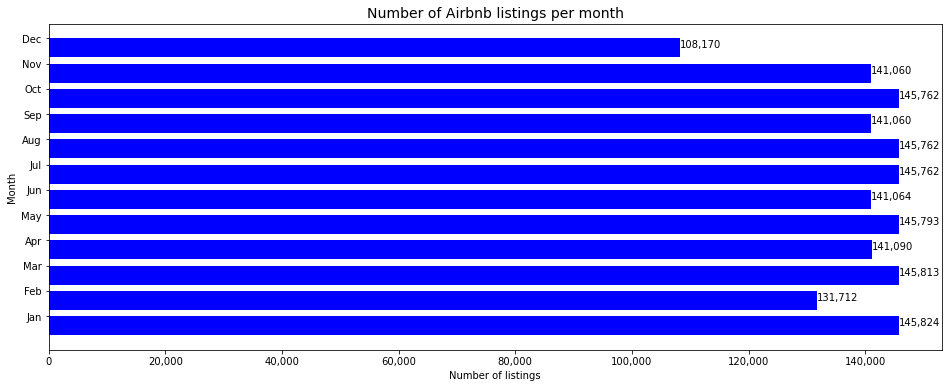

In [22]:
# Display the numbers of the previous table as a bar chart
# Data input for graphic:
x = [u'Jan', u'Feb', u'Mar', u'Apr', u'May', u'Jun', u'Jul', u'Aug', u'Sep', u'Oct', u'Nov', u'Dec']
y = no_listings_per_month['number_of_listings'].to_list() # Convert column number_of_listings into a list as input

fig, ax = plt.subplots() 

fig.set_size_inches(16, 6)
width = 0.75 # The width of the bars 
ind = np.arange(len(y))  # The x locations for the groups

ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
# Add comma decimal separator for each value in y
for index, value in enumerate(y):
    ax.text(value, index, str(format(value, ',')), color='black')

plt.title('Number of Airbnb listings per month', fontsize=14)
plt.xlabel('Number of listings')
plt.ylabel('Month')      
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

### Question 1a: In which months are most Airbnb listings still available (total)?

In [23]:
def availability_rate_perc (df, level):
    """
    Calculates the percentage of availability rate per month for listings of a given dataframe (df).
    The input variable level defines the level of the results - total or for each roomtype. 
    If the user states another level than total or roomtype - print an error message and return None
    """
    if level=='total':
        listing_sum = df.groupby([df['date'].dt.year.rename('year'), df['date'].dt.month.rename('month'), 'available'])['listing_id'].sum()
    elif level =='roomtype':
        listing_sum = df.groupby([df['date'].dt.year.rename('year'), df['date'].dt.month.rename('month'), 'available', 'room_type'])['listing_id'].sum()
    else:
        print("Please correct your level. The following values for level are valid: total and roomtype.")
        return    
    availability_perc = (listing_sum / listing_sum.groupby(level=[0, 1]).transform("sum")*100)
    #Convert series to dataframe and rename column
    result = availability_perc.to_frame().rename(columns = {'listing_id':'percentage'}) 
    result = result.reset_index()
    return result
    
result_1a = availability_rate_perc(calendar_df_with_room_types, "total")
result_1a

,year,month,available,percentage
0,2021,1,False,32.547788
1,2021,1,True,67.452212
2,2021,2,False,28.155575
3,2021,2,True,71.844425
4,2021,3,False,32.533568
5,2021,3,True,67.466432
6,2021,4,False,51.661307
7,2021,4,True,48.338693
8,2021,5,False,51.846419
9,2021,5,True,48.153581


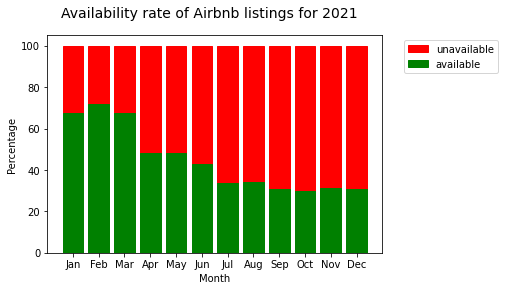

In [24]:
# Display the numbers of the previous table as a bar chart
# Set the labels
fig = plt.figure()
fig.suptitle('Availability rate of Airbnb listings for 2021', fontsize=14)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Percentage', fontsize=10)

# Transform the data - one list for each stack 
available = result_1a.query("available==True")["percentage"].values.tolist()
unavailable = result_1a.query("available==False")["percentage"].values.tolist()

# Make the stacked bar plot
columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pos = np.arange(len(columns))
p1 = plt.bar(pos, np.add(unavailable , available), color='red', edgecolor='red', label= 'unavailable')
p2 = plt.bar(pos, available, color='green', edgecolor='green', label= 'available')
plt.xticks(pos, columns)

# Create a legend
fontP = FontProperties()
fontP.set_size('medium')
plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

# Show graphic
plt.show()

### Result of question 1a:
February 2021 is the month with the highest availablity rate, followed by March 2021 and January 2021. This makes sense, if you think of the current Corona situation. People hesitate to book a room soon. October 2021 is the busiest month regarding the availablity rate. People look forward to go to the Octoberfest again.

### Question 1b: In which months are most Airbnb listings still available (by room_type)?

In [25]:
# see function availability_rate_perc, two cells above
result_1b = availability_rate_perc(calendar_df_with_room_types, "roomtype")
result_1b

,year,month,available,room_type,percentage
0,2021,1,False,Entire home/apt,21.252804
1,2021,1,False,Hotel room,0.512711
2,2021,1,False,Private room,10.579063
3,2021,1,False,Shared room,0.203210
4,2021,1,True,Entire home/apt,33.857044
5,2021,1,True,Hotel room,0.897881
6,2021,1,True,Private room,31.324853
7,2021,1,True,Shared room,1.372434
8,2021,2,False,Entire home/apt,19.604893
9,2021,2,False,Hotel room,0.155505


In [26]:
# Change from pivot table to normal table format; add column available
def prepare_df(df, name):
    """
    Selects all relevant columns of a given dataframe (df) for the plot and 
    replaces the values for the column available with the specified name
    We replace the name, as it is displayed in the legend of the stacked bar plot
    """
    df = df[['month', 'room_type', 'percentage','available']]
    df['available'] = name    
    return df

# Settings for displaying the chart
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
order = ['available', 'unavailable'] 

# Prepare the data 
unavailable_by_roomtype = result_1b.query("available==False")
unavailable_by_roomtype = prepare_df(unavailable_by_roomtype, 'unavailable')

available_by_roomtype = result_1b.query("available==True")
available_by_roomtype = prepare_df(available_by_roomtype, 'available')

# Join the two dataframes for the stack
df = pd.concat([available_by_roomtype, unavailable_by_roomtype]) 
# Convert values from month column to month name
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x]) 


# Make the stacked bar plot
chart = alt.Chart(df, title=['Availability rate of different Airbnb room types', '   ']).mark_bar().encode(

    # Use room type as x-axis 
    x=alt.X('room_type:N', title=None),

    # Use percentage as y-axis 
    y=alt.Y('sum(percentage):Q',
        axis=alt.Axis(
            grid=False,
            title='Percentage')),

    # Use month as the set of columns to be represented in each group
    column=alt.Column('month:N',  title=None, sort=months),

    # Set the colours 
    color=alt.Color('available:N', sort=order, 
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['green', 'red']
            ), title =None, 
        ), 
    # Determine the order for displaying (we want available on the bottom)
    order="order:Q" 
    )

#Configure the chart and display it
chart.configure_view(strokeOpacity=0)

C:\Users\wacke-al\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\wacke-al\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


alt.Chart(...)

### Result of question 1b:
Entire home/apartments, private rooms and shared rooms have the hightest availability rate in Jan, Feb and Mar 2021. Only hotel rooms are more booked in January 2021 compared to the other months.

# Question 2: In which Munich areas (zip codes) are the best Airbnb listings (according to total rating)?

In [27]:
# Show the number of each rating score for each zip code 
listings_df_without_missing_values.groupby(['zip_code','review_scores_rating']).size().unstack()

review_scores_rating,20.0,25.0,40.0,47.0,50.0,57.0,60.0,64.0,66.0,67.0,68.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
zip_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
80331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,2.0,1.0,4.0,1.0,1.0,3.0,4.0,6.0,5.0,21.0
80333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,1.0,6.0,6.0,4.0,2.0,1.0,5.0,7.0,9.0,10.0,2.0,20.0
80335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,1.0,NaN,NaN,3.0,2.0,2.0,5.0,3.0,2.0,4.0,3.0,5.0,6.0,2.0,4.0,1.0,25.0
80336,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,7.0,NaN,NaN,2.0,3.0,NaN,1.0,8.0,3.0,3.0,4.0,4.0,8.0,7.0,5.0,14.0,5.0,10.0,9.0,3.0,39.0
80337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,2.0,5.0,3.0,2.0,3.0,16.0,10.0,7.0,10.0,9.0,8.0,48.0
80339,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,NaN,NaN,1.0,2.0,3.0,1.0,7.0,5.0,NaN,4.0,4.0,8.0,11.0,7.0,8.0,8.0,38.0
80469,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,1.0,2.0,5.0,4.0,1.0,5.0,6.0,7.0,19.0,18.0,17.0,11.0,38.0
80538,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,4.0,2.0,3.0,4.0,7.0,5.0,2.0,17.0
80539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,4.0


In [28]:
# Calculate mean review_score for each zip code
res_2 = listings_df_without_missing_values[["review_scores_rating", "zip_code"]].groupby(['zip_code']).agg(['count','mean'])

# Change headers
res_2 = res_2.reset_index()
res_2.columns = res_2.columns.droplevel(0) 
res_2 = res_2.rename(columns={res_2.columns[0]: "zip_code", res_2.columns[1]: "number_of_scores", res_2.columns[2]: "average_score" })

# Display result
pd.set_option('display.max_rows', 100)
print(res_2.head(100))


   zip_code  number_of_scores  average_score
0     80331                57      95.456140
1     80333                83      94.481928
2     80335                75      93.933333
3     80336               143      92.720280
4     80337               131      96.114504
5     80339               114      95.122807
6     80469               143      95.699301
7     80538                53      94.433962
8     80539                10      98.200000
9     80634                39      95.717949
10    80636                70      97.100000
11    80637                57      94.421053
12    80638                11      92.727273
13    80639                37      97.594595
14    80686                36      97.000000
15    80687                72      95.708333
16    80689                29      95.551724
17    80796                85      95.882353
18    80797                54      94.518519
19    80798                74      96.081081
20    80799                75      95.040000
21    8080

We can see that the ratings are very high for all listings (all above 90).
Some of the zip codes only have a few ratings.

In [29]:
# Replace those average_score values with Nan, which have less or equals 10 ratings
minimum_number = 10
res_2[res_2.columns[2]].where((res_2[res_2.columns[1]] > minimum_number) ,np.NaN,inplace=True) 
# Sort the results by average score column
res_2 = res_2.sort_values(by=res_2.columns[2], ascending=False)
res_2.head(100)

,zip_code,number_of_scores,average_score
44,81373,68,97.661765
13,80639,37,97.594595
38,81243,17,97.352941
10,80636,70,97.100000
55,81545,14,97.071429
14,80686,36,97.000000
71,81925,29,96.655172
67,81739,32,96.625000
72,81927,48,96.479167
64,81679,31,96.451613


Zip codes with an average rating score above 97 are: 81373, 80639, 81243, 80636, 81545, and 80686. However, from this graphics, we cannot see where the the zip codes are located. Let's draw them on a map.

In [30]:
# Get polygon geometry data for the plot
pd.set_option('display.max_rows', 100)
plot_input_data = pd.merge(left=res_2, right=gdf_locations, on='zip_code', how='left')
plot_input_data.head(100)

,zip_code,number_of_scores,average_score,geometry
0,81373,68,97.661765,"POLYGON ((11.52015 48.12367, 11.52190 48.12607..."
1,80639,37,97.594595,"POLYGON ((11.48173 48.15556, 11.48224 48.15552..."
2,81243,17,97.352941,"POLYGON ((11.41761 48.15556, 11.44567 48.15291..."
3,80636,70,97.100000,"POLYGON ((11.53467 48.14280, 11.53607 48.14649..."
4,81545,14,97.071429,"MULTIPOLYGON (((11.55607 48.07994, 11.55640 48..."
5,80686,36,97.000000,"POLYGON ((11.49168 48.13978, 11.49175 48.13995..."
6,81925,29,96.655172,"POLYGON ((11.60502 48.15697, 11.60535 48.15696..."
7,81739,32,96.625000,"POLYGON ((11.66202 48.09939, 11.66438 48.10122..."
8,81927,48,96.479167,"POLYGON ((11.62827 48.14717, 11.62861 48.15100..."
9,81679,31,96.451613,"POLYGON ((11.59817 48.14935, 11.60502 48.15697..."


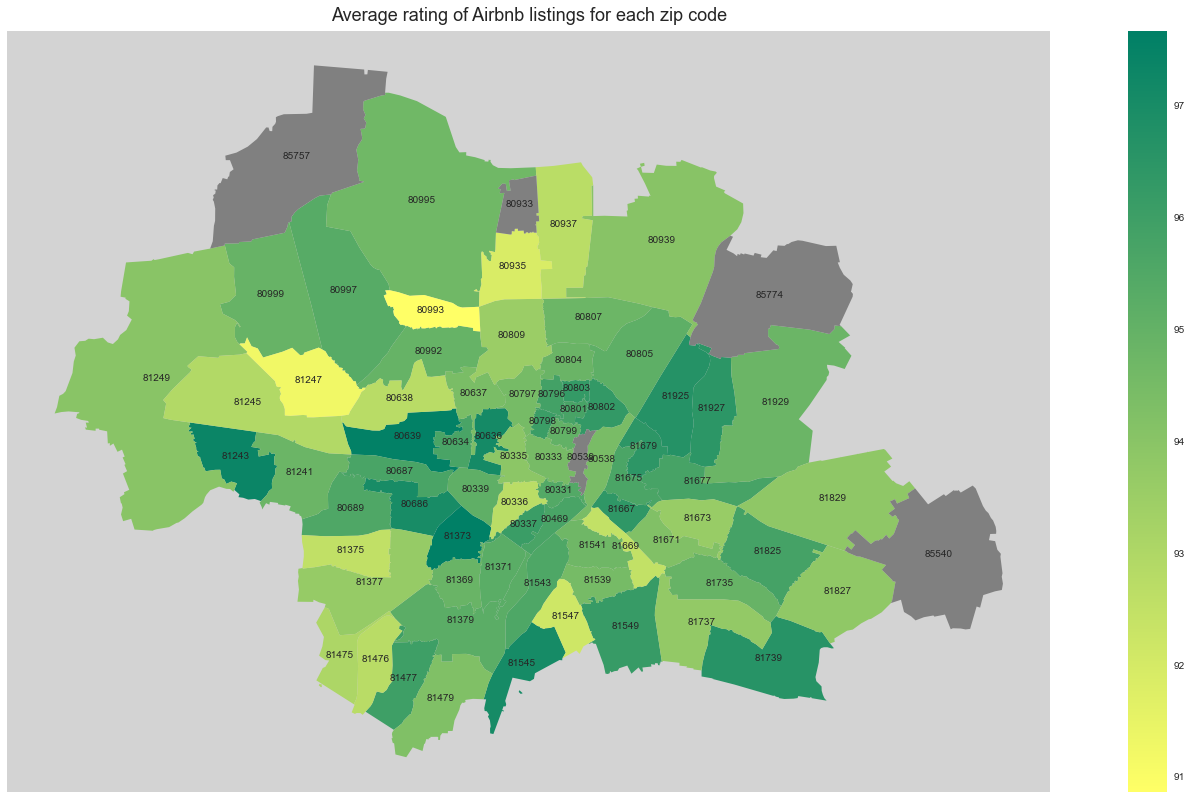

In [31]:
def plot_map(input_data, title, plot_type):
    """
    Plots a map of the input_data and writes the given title to the plot
    There a two types of plots: 
    - zip_code: includes the zip_code labels and draws them into the map
    - listings: does not draw the zip_code labels into the map, but draws all listing objects as a black point into the map
    """
    
    # Create the plot
    plt.style.use('seaborn')
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(28,14))

    # Highlight zip codes with NaN values in grey colour
    GeoDataFrame(input_data).plot(ax=ax, column=input_data.columns[2], categorical=False, legend=True, cmap='summer_r',
                                       missing_kwds=dict(color='grey'))
    if plot_type=="listings":
        listings_df_without_missing_values['const']=1  
        GeoDataFrame(listings_df_without_missing_values).plot(ax=ax, column='const', categorical=False, legend=False, cmap='gray');

    #Set the title
    ax.set_title(title, pad=10, fontsize=18)

    # Remove axis labels for latitude and longitude
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(facecolor='lightgrey');

    # Add zip code labels
    if plot_type=="zip_code":
        input_data.apply(lambda x: ax.annotate(text=x.zip_code, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

plot_map (plot_input_data, 'Average rating of Airbnb listings for each zip code', "zip_code")

Annotation: Zip codes with less or equal 10 ratings were excluded from the analysis and marked in dark gray.

### Result of question 2:
It seems that most of the popular areas (zip codes: 81373, 80639, 81243, 80636, and 80686) are placed in the West of Munich. This area has very good traffic connections to the inner city and also to the Oktoberfest. The only exception is the zip 81545, which is placed in the South of Munich, near to the big forest Perlacher Forst.

As some the zip codes in the West of Munich like Laim have lower house/appartment prices compared to other areas, let's investigate the relationship between listing price and listing (total) rating.

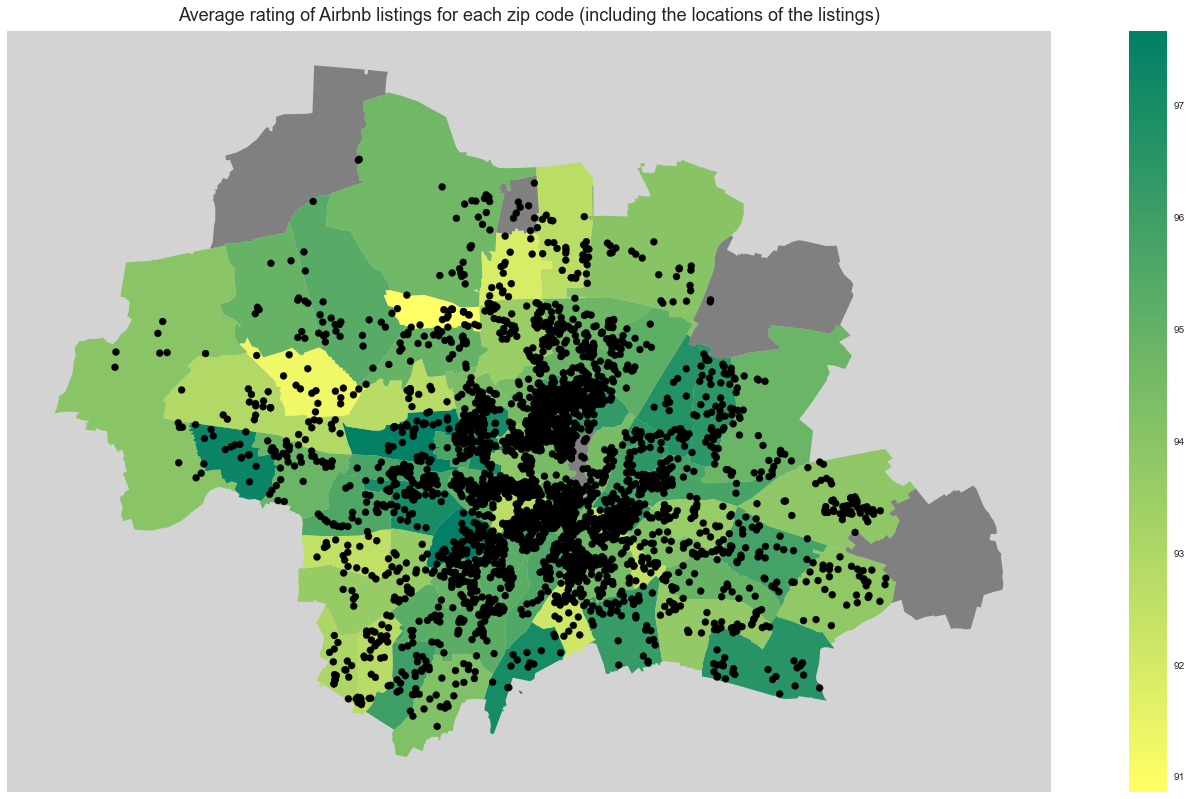

In [32]:
# Same plot including all listings (black points in map)
plot_map (plot_input_data, 'Average rating of Airbnb listings for each zip code (including the locations of the listings)', "listings")    

From the second plot, we can see that most of the Airbnb listings are located near to the inner city.

# Question 3: Do cheaper listings have a lower rating compared to more expensive listings? 

The relevant features for question 3 are price and review_scores_rating. As described in section data preparation, we use the listings dataframe without missing values:

In [33]:
listings_df_without_missing_values[["price", "review_scores_rating"]].describe()

,price,review_scores_rating
count,3595.000000,3595.000000
mean,104.998887,95.014465
std,187.747368,7.805532
min,10.000000,20.000000
25%,49.000000,93.000000
50%,73.000000,97.000000
75%,110.000000,100.000000
max,8000.000000,100.000000


The high standard deviation of the coloumn price (188) indicates that the data are more spread out. Prices in Dollar range between 10 and 8000. The values of review_scores_rating range between 20 and 100 with a standard deviation of only 8.

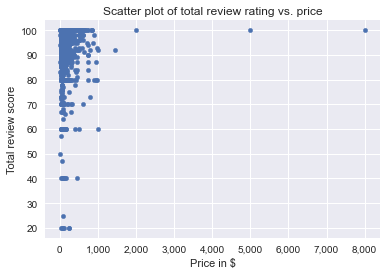

In [34]:
# Scatter plot to describe relationship between price and (total) rating

def scatter_plot(df, title):
    """
    plots a scatter plot for a given dataframe (df) and 
    sets the title description to the input variable "title"
    """
    ax = df.plot(kind='scatter', x='price', y='review_scores_rating')

    plt.xlabel('Price in $')
    plt.ylabel('Total review score')
    plt.title(title)

    # Add comma decimal separator 
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()
    
scatter_plot(listings_df_without_missing_values, 'Scatter plot of total review rating vs. price')

From the scatter plot, we can see the outliers.

In [35]:
# Remove outliers by querying the rows with a price less than $600
price_less_than_600 = listings_df_without_missing_values.query('price <= 600') # input data for scatter plot
count_outliers = len(listings_df_without_missing_values[listings_df_without_missing_values['price'] > 600])
percentage_outliers = count_outliers / listings_df_without_missing_values.shape[0] * 100
print('We found {} rows ({:.2f}%) with a price more than $600.'.format(count_outliers, percentage_outliers))

We found 30 rows (0.83%) with a price more than $600.


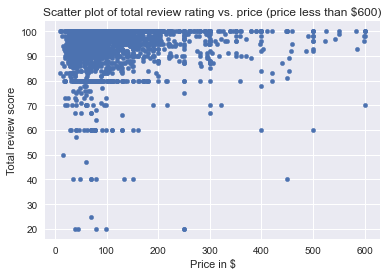

In [36]:
scatter_plot(price_less_than_600, 'Scatter plot of total review rating vs. price (price less than $600)')

### Result of question 3:
From the scatter plot, we can see that there is hardly no relationship between total review score and price. Many listings in the lower price range also have very high ratings.

<AxesSubplot:>

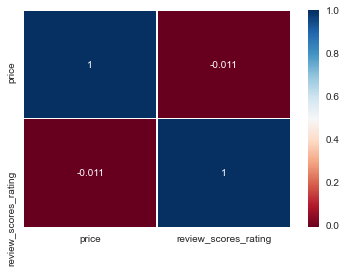

In [37]:
pearsoncorr = price_less_than_600[["price", "review_scores_rating"]].corr(method='pearson')

sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu',
            annot=True,
            linewidth=0.5)

From the results of the correlation coefficient, we come to the same conclusion: the correlation coefficient of -0.011 is considered as negligible correlation.